In [1]:
import localgraphclustering as lgc

import time
import numpy as np

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')
    
import pickle

In [2]:
# Read graph. This also supports gml and graphml format.
g = lgc.GraphLocal('./datasets/senate.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [3]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/senate.graphml")
    
remove_self_loops(g_gtool)

# Compute a layout for the graph.
#pos = sfdp_layout(g_gtool, gamma=10.0, mu=10.0, mu_p=10.0, verbose = False)  

coordinates = pickle.load( open( "./datasets/senate_pos.p", "rb" ) )

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = coordinates[g_gtool.vertex(i)]

print("Done!")

Done!


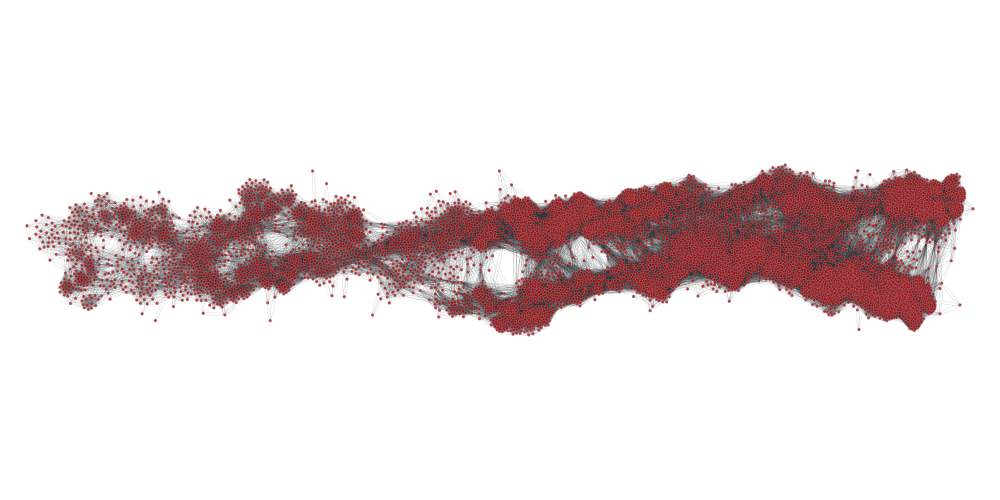

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x135438e10, at 0x10e1f6400>

In [4]:
# Plot solutions for global eigenvector

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=3,
           edge_pen_width=0.1,
           vcmap=c_map
           #output='./tmp/senate.png')
          )

# For exaplanation of the senate data please refer to
# K. Fountoulakis, D. Gleich and M. Mahoney, An optimization approach to locally-biased graph algorithms,
# Proceedings of the IEEE 105 (2), 256-272.

In [5]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

There are  1  connected components in the graph


<class 'localgraphclustering.ncp.NCPData'>


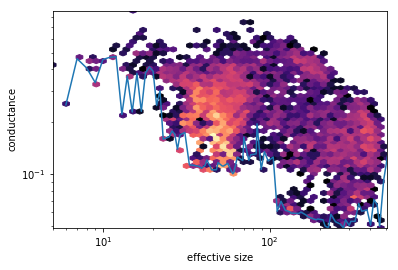

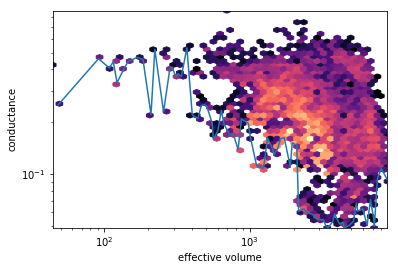

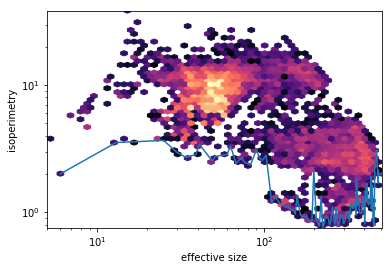

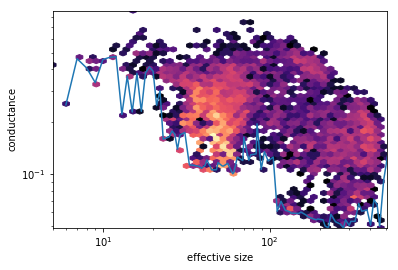

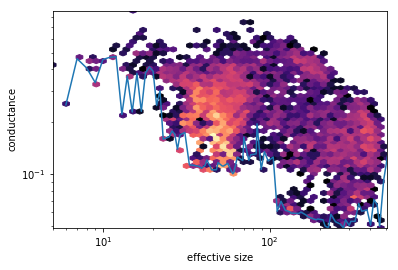

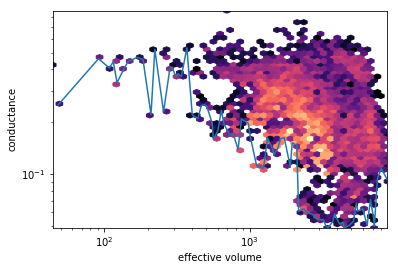

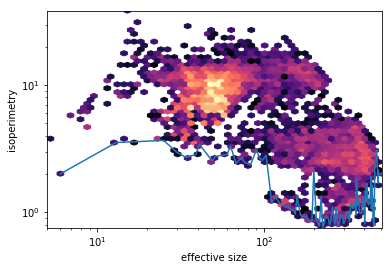

In [8]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [12]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/JohnsHopkins.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


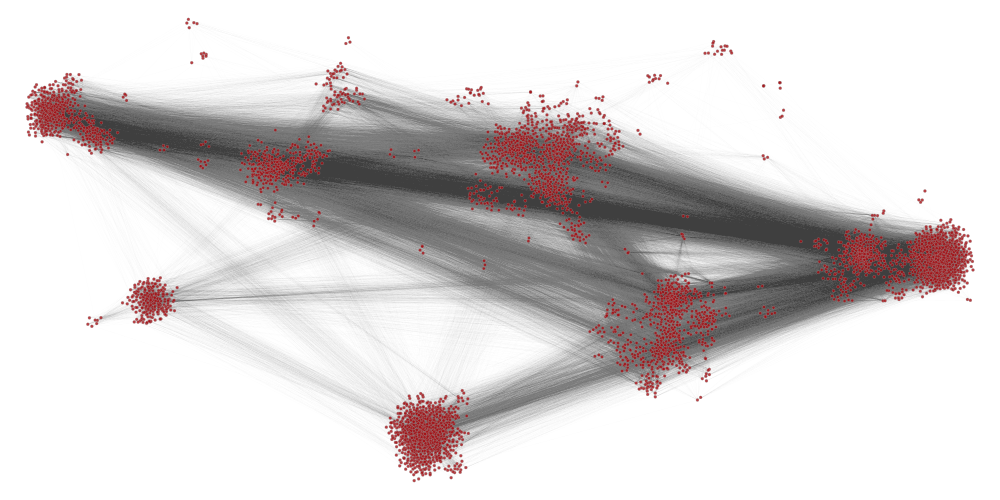

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1451eb860, at 0x1451eb668>

In [13]:
## Add data to graphtool.
g_gtool = load_graph("./datasets/JohnsHopkins.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
c_map = plt.get_cmap('autumn')

# Plot solutions for rounded eigenvector
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=3,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap=c_map
           #output='./tmp/JohnsHopkins.png')
          )

In [14]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

There are  1  connected components in the graph


<class 'localgraphclustering.ncp.NCPData'>


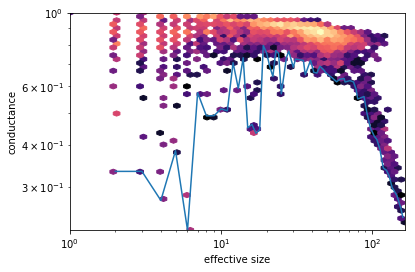

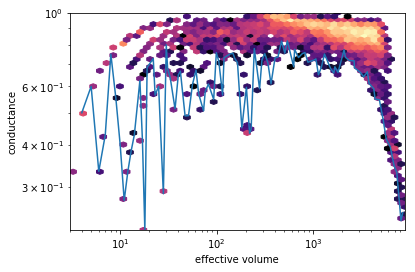

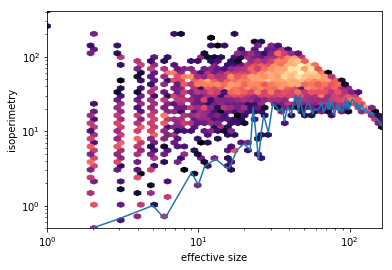

In [15]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [ ]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/usroads-cc.graphml','graphml')

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/usroads-cc.xy', dtype = 'Float64')
ld_coord[:,0] = -ld_coord[:,0]

In [ ]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/usroads-cc.graphml")
    
remove_self_loops(g_gtool)

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = -ld_coord[i,:]

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=1,
           edge_pen_width=0.5,
           vcmap=c_map
           #output='./tmp/usroad.png')
          )

In [ ]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

In [ ]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [17]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/ca-GrQc-cc.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [18]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/ca-GrQc-cc.graphml")
    
remove_self_loops(g_gtool)

# Compute a layout for the graph.
# pos = sfdp_layout(g_gtool, gamma=10.0, mu=10.0, mu_p=10.0, verbose = False)  

coordinates = pickle.load( open( "ca-GrQc-cc_xy.p", "rb" ) )

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = coordinates[g_gtool.vertex(i)]

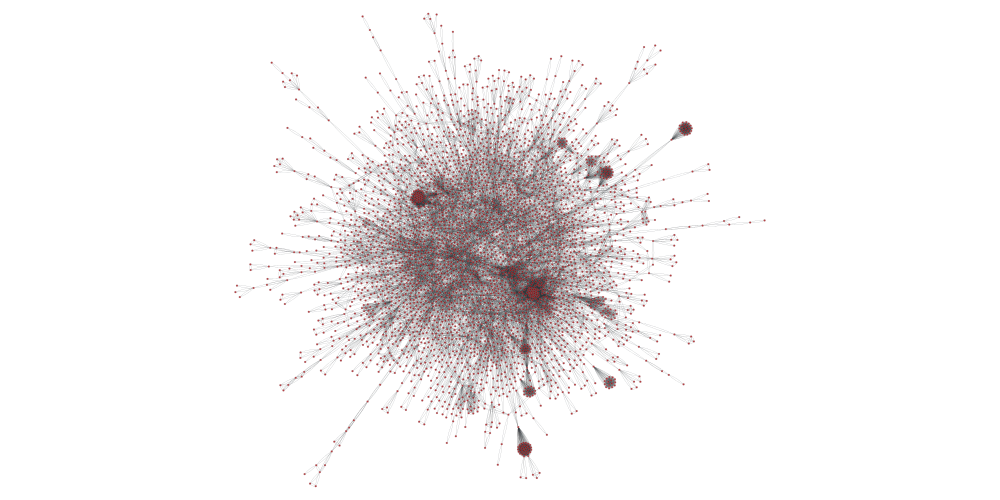

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x135d711d0, at 0x135d71278>

In [19]:
# Plot solutions for global eigenvector

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=2,
           edge_pen_width=0.1,
           vcmap=c_map
           #output='./tmp/ca-GrQc-cc.png')
          )

In [20]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

There are  1  connected components in the graph


<class 'localgraphclustering.ncp.NCPData'>


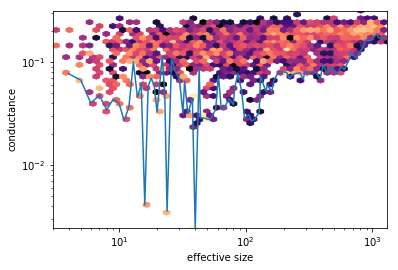

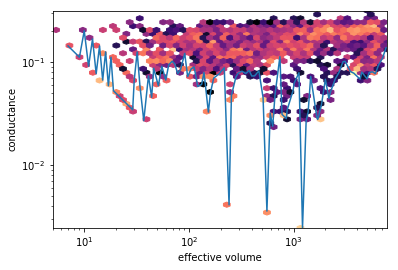

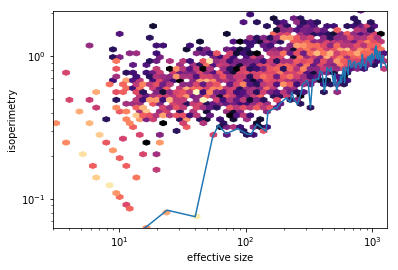

In [21]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()